In [2]:
!pip list

Package                   Version
------------------------- ----------------
absl-py                   2.1.0
accelerate                0.33.0
ace                       0.3.3
ace_tools                 0.0
adalflow                  0.2.0
aiofiles                  23.2.1
aiohttp                   3.9.5
aiosignal                 1.3.1
altair                    5.3.0
annotated-types           0.7.0
anyio                     4.3.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
astrapy                   0.7.3
astroid                   3.2.4
asttokens                 2.4.1
astunparse                1.6.3
async-lru                 2.0.4
attrs                     23.2.0
Babel                     2.14.0
backoff                   2.2.1
beautifulsoup4            4.12.3
bleach                    6.1.0
blinker                   1.8.2
blis                      0.7.11
boto3                     1.35.11
botocore                  1.35.11
Bottleneck       

In [10]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [11]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 49 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

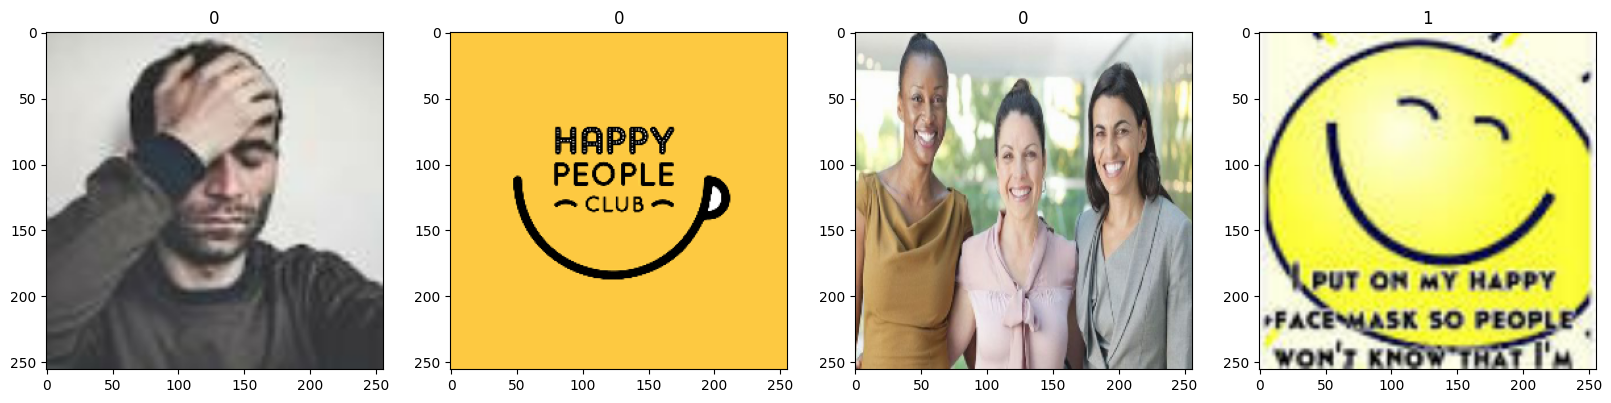

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.9764706 , 0.9764706 , 0.94509804],
          [0.9764706 , 0.9764706 , 0.94509804],
          [0.9764706 , 0.9764706 , 0.94509804],
          ...,
          [0.5568628 , 0.5116728 , 0.47444853],
          [0.5677696 , 0.5285539 , 0.48933825],
          [0.58311886, 0.5439032 , 0.5046875 ]],
 
         [[0.9764706 , 0.9764706 , 0.94509804],
          [0.9764706 , 0.9764706 , 0.94509804],
          [0.9764706 , 0.9764706 , 0.94509804],
          ...,
          [0.5604779 , 0.515288  , 0.47806373],
          [0.5713848 , 0.5321691 , 0.49295342],
          [0.58673406, 0.5475184 , 0.5083027 ]],
 
         [[0.9764706 , 0.9764706 , 0.94509804],
          [0.9764706 , 0.9764706 , 0.94509804],
          [0.9764706 , 0.9764706 , 0.94509804],
          ...,
          [0.5660968 , 0.5209068 , 0.48368254],
          [0.576929  , 0.5377133 , 0.49849758],
          [0.5921569 , 0.5529412 , 0.5137255 ]],
 
         ...,
 
         [[0.22352941, 0.14509805, 0.10980392],
          [0.22352

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

7

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [19]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\Nhat Minh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step - accuracy: 0.4950 - loss: 0.9315 - val_accuracy: 0.5781 - val_loss: 0.6639
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - accuracy: 0.5151 - loss: 0.6801 - val_accuracy: 0.6875 - val_loss: 0.6324
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.6621 - loss: 0.6245 - val_accuracy: 0.6719 - val_loss: 0.5708
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.7704 - loss: 0.5356 - val_accuracy: 0.7500 - val_loss: 0.4882
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.7414 - loss: 0.5137 - val_accuracy: 0.8125 - val_loss: 0.3768
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.8608 - loss: 0.3721 - val_accuracy: 0.9062 - val_loss: 0.3178
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - accuracy: 0.8788 - loss: 0.3190 - val_accuracy: 0.7656 - val_loss: 0.3655
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.8192 - loss: 0.3783 - val_accuracy: 0.8594 - val_loss:

# 8. Plot Performance

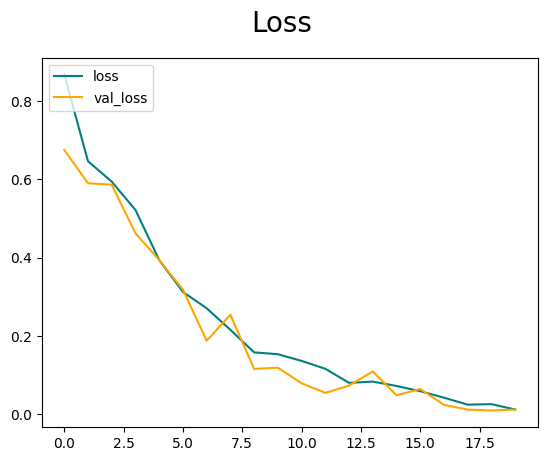

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

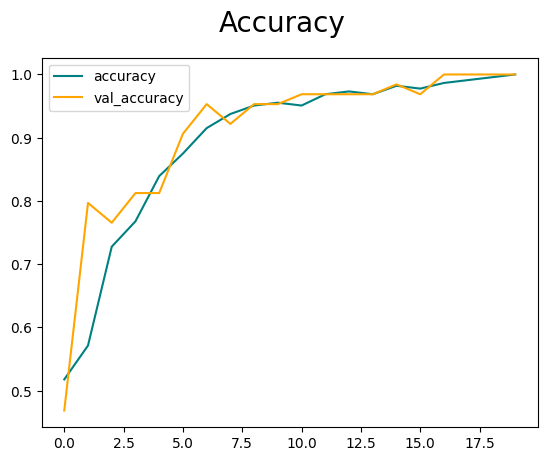

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [30]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [31]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [32]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


In [33]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [34]:
import cv2

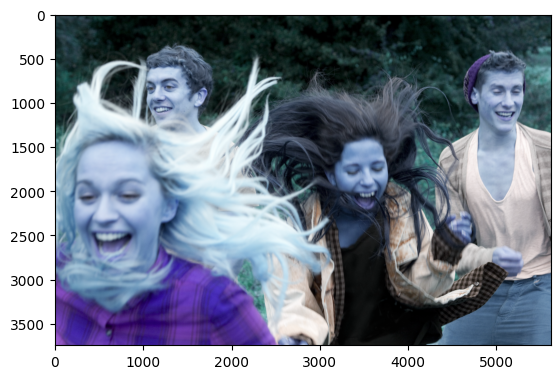

In [35]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

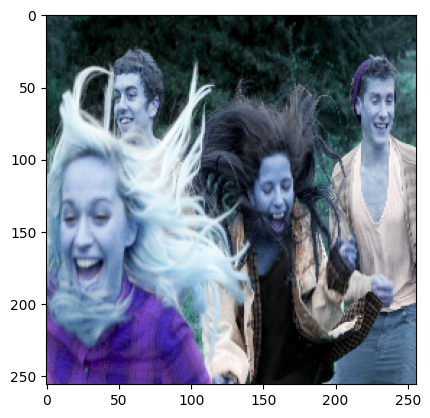

In [36]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [42]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [43]:
yhat

array([[0.9292247]], dtype=float32)

In [44]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [45]:
from tensorflow.keras.models import load_model

In [46]:
model.save(os.path.join('models','imageclassifier.h5'))

In [47]:
new_model = load_model('imageclassifier.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'imageclassifier.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)